In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.dates as mdates


In [11]:
def load_cover_trace(filename):
    data = pd.read_csv(filename)
    data = data.sort_values(by="timestamp").reset_index(drop=True)
    
    # Ensure that the trace starts with packet number zero
    assert data.loc[0, "packet_number"] == 0
    data["timestamp"] = (data["timestamp"] - data.loc[0, "timestamp"]) * 1e3
    
    # Drop all packets with packet number zero as they're only there for the starting time
    data = data[data["packet_number"] != 0].reset_index(drop=True)
    
    data = data.rename(columns={"timestamp": "time", "chaff_traffic": "length"})
    data = data[["time", "length", "other_traffic", "packet_length", "is_outgoing"]]
    data["time"] = pd.to_datetime(data["time"], unit="ms")
    
    data = data.groupby("is_outgoing").resample("5ms", on="time", origin="epoch").sum().drop(columns="is_outgoing")
    #data["time"] = (data["time"]- dt.datetime(1970,1,1)).dt.total_seconds()
    return data
    
    
data = load_cover_trace("../results/collect/front_defended/007_0/front_cover_traffic.csv")
display(data)
print(type(data.xs(True)["length"]))
display(data.xs(True)["length"])
display(data.xs(False))

,is_outgoing,time,length,other_traffic,packet_length
0,False,1970-01-01 00:00:00.005,0,43,1400
1,False,1970-01-01 00:00:00.010,0,0,0
2,False,1970-01-01 00:00:00.015,0,0,0
3,False,1970-01-01 00:00:00.020,0,0,26
4,False,1970-01-01 00:00:00.025,0,0,25
...,...,...,...,...,...
2673,True,1970-01-01 00:00:06.685,0,0,0
2674,True,1970-01-01 00:00:06.690,0,0,0
2675,True,1970-01-01 00:00:06.695,0,0,133
2676,True,1970-01-01 00:00:06.700,0,0,0


KeyError: True

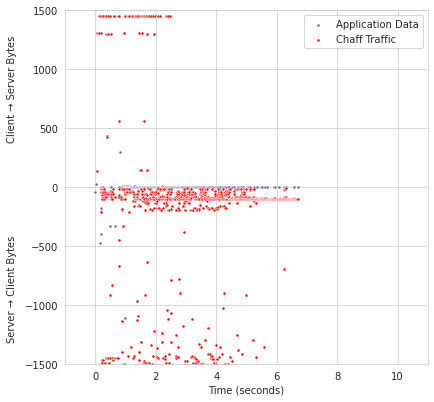

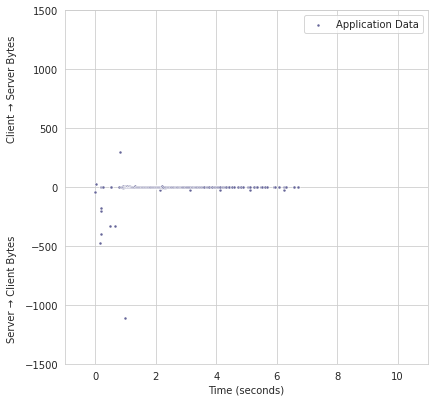

In [5]:
def plot(data, with_chaff: bool = True):
    with sns.axes_style("whitegrid"):
        data = data.copy().reset_index()
        data.loc[~data["is_outgoing"], ["length", "other_traffic", "packet_length"]] \
            = data[~data["is_outgoing"]][["length", "other_traffic", "packet_length"]] * -1

        figure, axes = plt.subplots(1, 1, figsize=(6.5, 6.5))

        other_traffic = data[data["other_traffic"] != 0]
        sns.scatterplot(x="time", y="other_traffic", data=other_traffic, marker='.', ax=axes, label="Application Data", color="#666699")
        
        if with_chaff:
            chaff_traffic = data[data["length"] != 0]
            sns.scatterplot(x="time", y="length", data=chaff_traffic, marker='.', ax=axes, label="Chaff Traffic", color="red")

        
        # axes.xaxis.set_major_formatter(mdates.DateFormatter("%S"))
        axes.set_ylim(-1500, 1500)
        axes.set_xlim(-1, 11)
        
        axes.set_xlabel("Time (seconds)")
        axes.set_ylabel("")
        
        axes.text(-2.75, -1300, "Server → Client Bytes", rotation=90, horizontalalignment="center")
        axes.text(-2.75, 400, "Client → Server Bytes", rotation=90, horizontalalignment="center")
        
        return figure
    
figure = plot(data, with_chaff=True)
figure.savefig("icrc-chaff-plot.png", dpi=300, bbox_inches="tight")

figure = plot(data, with_chaff=False)
figure.savefig("icrc-base-plot.png", dpi=300, bbox_inches="tight")